# Prepare Video Clip Frames and Optical Flow Images
Learning algorithms take rgb images and optionally optical flow images as input. Therefore, we need to extract the frames from the video clips and their corresponding optical flow. This notebook provides two main functions:

1. Rewrite the video cilps and generate the optical flows for the corresponding video clips
2. Extract farmes from the video clips and their corresponding optical flows.

that are implemented in two python scripts:
1. rewrite_video_clip_and_generate_optical_flow.py
2. extract_frames_from_rgb_and_opt_video_clip.py

The notebook is mainly to test the scripts and generate and submit job scripts that are used to parallelly process the video clips in smaller batches to reduce the processing time. For example, preparing frames and optical flow images for each video clip nomally costs a few minutes. Assuming processing one clip costs 4 minutes, for the total about 2650 clips in the dataset, this will cost about 177hours on a single PC, while if we also consider to process the video clips not included in the dataet, which is 18527 in total, this will cost 1235hours on a single PC. Therefore, to faciliate faster preparation, we can use this notebook to generate hundreds of jobs to simultaneously process hundreds of batches of video clips.

*Hint*: If you do not have access to High Performance Computing (HPC) that allows you to submit hundreds of video clips, please contact the researchers to share the preprocessed data with you in order to save your time.

In [1]:
import os
import pandas as pd
import numpy as np
import subprocess
from tqdm import tqdm
import time
import shutil
import cv2
import zipfile

In [2]:
def ffmpeg(filename, outfile, fps):
    """
    Function used to extract frames from a video at the given FPS and resolution.
    """
    command = ["ffmpeg", "-i", filename, "-s", "1600*900", "-r", str(fps), outfile]
    pipe = subprocess.Popen(command, stdout = subprocess.PIPE, stderr = subprocess.STDOUT)
    pipe.communicate()

In [3]:
csv_data_path = r"/project/6055479/lingheng/cyc_near_miss/dataset_utils/dataset_vic_cyc_legacy/NearMiss_classification.csv"
csv_data_df = pd.read_csv(csv_data_path)
csv_data_df

,RiderID,TripNumber,ClipName,ClipFramePath,VideoName,FramePath,Time,Press,Pass_Distance,NearMiss,Seconds,SignedSpeed,Split
0,26,4,PassingEvent_Duration10s_007937.mp4,PassingEvent_Duration10s_007937,Trip_4.0_GOPR0008.LRV,MPDS_026/Trip_4.0_GOPR0008,00:05:46.440000,0,92.5,1,372,60.0,train
1,9,7,PassingEvent_Duration10s_002240.mp4,PassingEvent_Duration10s_002240,Trip_7.1_GP010109.LRV,MPDS_009/Trip_7.1_GP010109,00:12:42.789000,0,94.5,1,809,50.0,train
2,7,6,PassingEvent_Duration10s_001408.mp4,PassingEvent_Duration10s_001408,Trip_6.0_GOPR0017.LRV,MPDS_007/Trip_6.0_GOPR0017,00:08:37.620000,0,165.0,0,554,50.0,train
3,26,4,PassingEvent_Duration10s_008071.mp4,PassingEvent_Duration10s_008071,Trip_4.1_GP010008.LRV,MPDS_026/Trip_4.1_GP010008,00:07:08.873000,0,99.5,1,480,60.0,train
4,28,1,PassingEvent_Duration10s_008726.mp4,PassingEvent_Duration10s_008726,Trip_1.0_GOPR2113.LRV,MPDS_028/Trip_1.0_GOPR2113,00:05:55.889000,0,92.0,1,408,60.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,30,7,PassingEvent_Duration10s_009208.mp4,PassingEvent_Duration10s_009208,Trip_7.1_GP014721.LRV,MPDS_030/Trip_7.1_GP014721,00:14:56.828000,0,99.0,1,946,60.0,test
2638,2,7,PassingEvent_Duration10s_000192.mp4,PassingEvent_Duration10s_000192,Trip_7.0_GOPR0008.LRV,MPDS_002/Trip_7.0_GOPR0008,00:09:34.780000,0,126.5,0,621,60.0,test
2639,20,9,PassingEvent_Duration10s_004313.mp4,PassingEvent_Duration10s_004313,Trip_9.0_GOPR0036.LRV,MPDS_020/Trip_9.0_GOPR0036,00:11:44.882000,0,76.0,1,757,50.0,test
2640,34,5,PassingEvent_Duration10s_010041.mp4,PassingEvent_Duration10s_010041,Trip_5.3_GP033968.LRV,MPDS_034/Trip_5.3_GP033968,00:02:29.316000,0,31.0,1,168,60.0,test


## Task 1: Generate optical flow from video clip
**Note**: Because the video clips normally have lower fps than 25, if we extract frames at fps=25, we may have two consecutive frames are exactly the same which will cause the optical flow image to 0 at every pixel. Therefore, we should first calculate optical flow from the video clips then extract frames with a given fps, rather than extract frames first and then calculate optical flow from the extracted frames.

### (Optional) Test rewrite_video_clip_and_generate_optical_flow.py script

In [4]:
cyc_video_path = "/project/6055479/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip/"  # Path to all video clips

cyc_video_rgb_path = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_rgb/"  # Destination to save rewritten video clips
cyc_video_opt_path = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_opt/"  # Destination to save optical flow videos
if not os.path.exists(cyc_video_rgb_path):
    os.makedirs(cyc_video_rgb_path)
if not os.path.exists(cyc_video_opt_path):
    os.makedirs(cyc_video_opt_path)

fps = 25
    
video_clip_list = os.listdir(cyc_video_path)
video_clip_list.sort()
video_clip_list

['PassingEvent_Duration10s_000001.mp4',
 'PassingEvent_Duration10s_000003.mp4',
 'PassingEvent_Duration10s_000005.mp4',
 'PassingEvent_Duration10s_000006.mp4',
 'PassingEvent_Duration10s_000007.mp4',
 'PassingEvent_Duration10s_000008.mp4',
 'PassingEvent_Duration10s_000009.mp4',
 'PassingEvent_Duration10s_000010.mp4',
 'PassingEvent_Duration10s_000011.mp4',
 'PassingEvent_Duration10s_000012.mp4',
 'PassingEvent_Duration10s_000015.mp4',
 'PassingEvent_Duration10s_000016.mp4',
 'PassingEvent_Duration10s_000017.mp4',
 'PassingEvent_Duration10s_000018.mp4',
 'PassingEvent_Duration10s_000019.mp4',
 'PassingEvent_Duration10s_000020.mp4',
 'PassingEvent_Duration10s_000021.mp4',
 'PassingEvent_Duration10s_000022.mp4',
 'PassingEvent_Duration10s_000023.mp4',
 'PassingEvent_Duration10s_000024.mp4',
 'PassingEvent_Duration10s_000025.mp4',
 'PassingEvent_Duration10s_000026.mp4',
 'PassingEvent_Duration10s_000027.mp4',
 'PassingEvent_Duration10s_000028.mp4',
 'PassingEvent_Duration10s_000029.mp4',


In [45]:

for video_clip in tqdm(video_clip_list[:1]):
    video_clip_path = os.path.join(cyc_video_path, video_clip)
    
    # The video feed is read in as a VideoCapture object
    video_cap = cv2.VideoCapture(video_clip_path)
    
    # Write frames and optical flow at the same fps, so we can keep the curract correspondance.
    frame_width = int(video_cap.get(3))
    frame_height = int(video_cap.get(4))
    clip_rgb_out_name = os.path.join(cyc_video_rgb_path, 'rgb_{}'.format(video_clip))
    clip_opt_out_name = os.path.join(cyc_video_opt_path, 'opt_{}'.format(video_clip))
    video_frame_rgb_out = cv2.VideoWriter(clip_rgb_out_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width,frame_height))
    video_frame_opt_out = cv2.VideoWriter(clip_opt_out_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width,frame_height))
    
    # ret = a boolean return value from getting the frame, first_frame = the first frame in the entire video sequence
    ret, first_frame = video_cap.read()
    video_frame_rgb_out.write(first_frame)    # wirte the first frame
    video_frame_opt_out.write(first_frame)    # the 1st frame does not have optical flow so just wirte the first frame
    
    # Read grayscale image because we only need the luminance channel for detecting edges - less computationally expensive
    prev_frame_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    
    # Creates an image filled with zero intensities with the same dimensions as the frame
    mask = np.zeros((prev_frame_gray.shape[0], prev_frame_gray.shape[1], 3), dtype=np.uint8)
    
    # Sets image saturation to maximum
    mask[..., 1] = 255
    while(video_cap.isOpened()):
        # Read a frame
        read_success, curr_frame = video_cap.read()
        if not read_success:
            print('Reach the end of video!')
            break
        # print(ret)
        # Converts each frame to grayscale - we previously only converted the first frame to grayscale
        curr_frame_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

        # Calculates dense optical flow by Farneback method
        flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, curr_frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # Computes the magnitude and angle of the 2D vectors
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        # Sets image hue according to the optical flow direction
        mask[..., 0] = angle * 180 / np.pi / 2

        # Sets image value according to the optical flow magnitude (normalized)
        mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

        # Converts HSV to RGB (BGR) color representation
        rgb_opt = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

        # Save
        # cv2.imwrite(os.path.join(video_clip_frame_optical_flow_folder_path, 'optical_flow_{}'.format(frame_name)), rgb_opt)
        video_frame_rgb_out.write(curr_frame)
        video_frame_opt_out.write(rgb_opt)

        prev_frame_gray = curr_frame_gray
         
    # When everything done, release the video capture and video write objects
    video_frame_rgb_out.release()
    video_frame_opt_out.release()

  0%|          | 0/1 [00:00<?, ?it/s]OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
100%|██████████| 1/1 [00:26<00:00, 26.16s/it]

Reach the end of video!


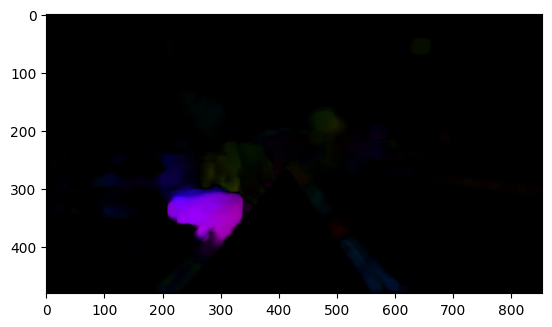

In [56]:
import matplotlib.pyplot as plt
video_cap = cv2.VideoCapture(video_clip_path)
read_success, curr_frame = video_cap.read()
curr_frame_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
mask = np.zeros((prev_frame_gray.shape[0], prev_frame_gray.shape[1], 3), dtype=np.uint8)

mask[..., 1] = 255
# Calculates dense optical flow by Farneback method
flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, curr_frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

# Computes the magnitude and angle of the 2D vectors
magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

# Sets image hue according to the optical flow direction
mask[..., 0] = angle * 180 / np.pi / 2

# Sets image value according to the optical flow magnitude (normalized)
mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

# Converts HSV to RGB (BGR) color representation
rgb_opt = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
plt.imshow(curr_frame)
plt.imshow(rgb_opt)
# rgb_opt

### Generate job scripts

In [63]:
raw_video_clip_path = r"/project/6055479/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip/"
new_video_clip_rgb_path = r"/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_rgb/"
new_video_clip_opt_path = r"/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_opt/"


In [64]:
job_script_root_dir = '/scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow'  # Where to save job scripts
job_output_root_dir = '/scratch/lingheng/cyc_safety_job_output_rewrite_clip_and_generate_optical_flow'   # Where to save job outputs
if not os.path.exists(job_script_root_dir):
    os.makedirs(job_script_root_dir)
else:
    # If exist, remove to avoid recreate job scripts
    shutil.rmtree(job_script_root_dir)
    os.makedirs(job_script_root_dir)
    
if not os.path.exists(job_output_root_dir):
    os.makedirs(job_output_root_dir)

In [65]:
batch_size = 100                                             # Specify how many clips will be precessed in one job
start_idx = np.arange(0, len(video_clip_list), batch_size)   # Specify the start clip id included within one job
end_idx = np.append(start_idx[1:], [len(video_clip_list)])   # Specify the end clip id included within one job

for b_i in range(len(start_idx)):
    # Get start and end id for the batch
    process_start_id = start_idx[b_i]
    process_end_id = end_idx[b_i]
    print('batch {}, start={}, end={}'.format(b_i, process_start_id, process_end_id))
    #
    job_script_name = 'job_rewrite_clip_and_generate_optical-{}-{}-{}.sh'.format(b_i, process_start_id, process_end_id)
    job_output_name = 'output_rewrite_clip_and_generate_optical-{}-{}-{}_R-%x.%j.out'.format(b_i, process_start_id, process_end_id)
    # Write batch job script
    with open(os.path.join(job_script_root_dir, job_script_name), 'w', encoding='utf8', newline='\n') as f:
        f.write('''\
#!/bin/bash
#SBATCH --account=def-rgorbet
#SBATCH --nodes=1                # When requesting GPUs per node the number of nodes must be specified.
#SBATCH --ntasks=5               # number of MPI processes
#SBATCH --mem-per-cpu=8000M          # memory; default unit is megabytes
#SBATCH --time=0-5:0         # time (DD-HH:MM)
#SBATCH --output={0}/{1}

module load python/3.7
source /home/lingheng/cyc_env/bin/activate
python /project/6055479/lingheng/cyc_near_miss/dataset_utils/dataset_vic_cyc_legacy/rewrite_video_clip_and_generate_optical_flow.py --raw_video_clip_path {2} --new_video_clip_rgb_path {3} --new_video_clip_opt_path {4} --process_start_id {5} --process_end_id {6}
                '''.format(job_output_root_dir, job_output_name,
                           raw_video_clip_path, new_video_clip_rgb_path, new_video_clip_opt_path, 
                           process_start_id, process_end_id))

batch 0, start=0, end=100
batch 1, start=100, end=200
batch 2, start=200, end=300
batch 3, start=300, end=400
batch 4, start=400, end=500
batch 5, start=500, end=600
batch 6, start=600, end=700
batch 7, start=700, end=800
batch 8, start=800, end=900
batch 9, start=900, end=1000
batch 10, start=1000, end=1100
batch 11, start=1100, end=1200
batch 12, start=1200, end=1300
batch 13, start=1300, end=1400
batch 14, start=1400, end=1500
batch 15, start=1500, end=1600
batch 16, start=1600, end=1700
batch 17, start=1700, end=1800
batch 18, start=1800, end=1900
batch 19, start=1900, end=2000
batch 20, start=2000, end=2100
batch 21, start=2100, end=2200
batch 22, start=2200, end=2300
batch 23, start=2300, end=2400
batch 24, start=2400, end=2500
batch 25, start=2500, end=2600
batch 26, start=2600, end=2700
batch 27, start=2700, end=2800
batch 28, start=2800, end=2900
batch 29, start=2900, end=3000
batch 30, start=3000, end=3100
batch 31, start=3100, end=3200
batch 32, start=3200, end=3300
batch 33

### Submit jobs

In [66]:
job_script_list = os.listdir(job_script_root_dir)
job_script_list.sort()
job_script_list

['job_rewrite_clip_and_generate_optical-0-0-100.sh',
 'job_rewrite_clip_and_generate_optical-1-100-200.sh',
 'job_rewrite_clip_and_generate_optical-10-1000-1100.sh',
 'job_rewrite_clip_and_generate_optical-100-10000-10100.sh',
 'job_rewrite_clip_and_generate_optical-101-10100-10200.sh',
 'job_rewrite_clip_and_generate_optical-102-10200-10300.sh',
 'job_rewrite_clip_and_generate_optical-103-10300-10400.sh',
 'job_rewrite_clip_and_generate_optical-104-10400-10500.sh',
 'job_rewrite_clip_and_generate_optical-105-10500-10600.sh',
 'job_rewrite_clip_and_generate_optical-106-10600-10700.sh',
 'job_rewrite_clip_and_generate_optical-107-10700-10800.sh',
 'job_rewrite_clip_and_generate_optical-108-10800-10900.sh',
 'job_rewrite_clip_and_generate_optical-109-10900-11000.sh',
 'job_rewrite_clip_and_generate_optical-11-1100-1200.sh',
 'job_rewrite_clip_and_generate_optical-110-11000-11100.sh',
 'job_rewrite_clip_and_generate_optical-111-11100-11200.sh',
 'job_rewrite_clip_and_generate_optical-112-

In [67]:
len(job_script_list)

186

In [68]:
for job_i, job_script in enumerate(job_script_list):
    job_script_path = os.path.join(job_script_root_dir, job_script)
    print('Submitting {}: {}'.format(job_i, job_script_path))
    !sbatch {job_script_path} 
    print("#########################################################################################")

Submitting 0: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-0-0-100.sh
Submitted batch job 63387814
#########################################################################################
Submitting 1: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-1-100-200.sh
Submitted batch job 63387815
#########################################################################################
Submitting 2: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-10-1000-1100.sh
Submitted batch job 63387816
#########################################################################################
Submitting 3: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-100-10000-10100.sh
Submitted batch job 63387817
###########################

Submitted batch job 63387861
#########################################################################################
Submitting 31: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-126-12600-12700.sh
Submitted batch job 63387862
#########################################################################################
Submitting 32: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-127-12700-12800.sh
Submitted batch job 63387863
#########################################################################################
Submitting 33: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-128-12800-12900.sh
Submitted batch job 63387864
#########################################################################################
Submitting 34: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip

Submitted batch job 63387892
#########################################################################################
Submitting 62: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-154-15400-15500.sh
Submitted batch job 63387893
#########################################################################################
Submitting 63: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-155-15500-15600.sh
Submitted batch job 63387894
#########################################################################################
Submitting 64: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-156-15600-15700.sh
Submitted batch job 63387895
#########################################################################################
Submitting 65: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip

Submitted batch job 63387924
#########################################################################################
Submitting 93: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-182-18200-18300.sh
Submitted batch job 63387926
#########################################################################################
Submitting 94: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-183-18300-18400.sh
Submitted batch job 63387933
#########################################################################################
Submitting 95: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-184-18400-18500.sh
Submitted batch job 63387935
#########################################################################################
Submitting 96: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip

Submitted batch job 63388117
#########################################################################################
Submitting 124: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-43-4300-4400.sh
Submitted batch job 63388120
#########################################################################################
Submitting 125: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-44-4400-4500.sh
Submitted batch job 63388125
#########################################################################################
Submitting 126: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-45-4500-4600.sh
Submitted batch job 63388129
#########################################################################################
Submitting 127: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_

Submitted batch job 63388180
#########################################################################################
Submitting 155: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-71-7100-7200.sh
Submitted batch job 63388181
#########################################################################################
Submitting 156: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-72-7200-7300.sh
Submitted batch job 63388182
#########################################################################################
Submitting 157: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_generate_optical_flow/job_rewrite_clip_and_generate_optical-73-7300-7400.sh
Submitted batch job 63388183
#########################################################################################
Submitting 158: /scratch/lingheng/cyc_safety_job_scripts_rewrite_clip_and_

Submitted batch job 63388236
#########################################################################################


## Task 2: Extract frames from rewritten video clips and their corresponding optical flows

### (Optinal) Test: extract_frames_from_rgb_and_opt_video_clip.py script

In [4]:
new_video_clip_rgb_path = r"/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_rgb/"
new_video_clip_opt_path = r"/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_opt/"

video_rgb_frame_root_path = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_rgb_frame"
video_opt_frame_root_path = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_opt_frame"
video_fused_frame_root_dir = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_fused_frame/"
if not os.path.exists(video_rgb_frame_root_path):
    os.mkdir(video_rgb_frame_root_path)
if not os.path.exists(video_opt_frame_root_path):
    os.mkdir(video_opt_frame_root_path)
if not os.path.exists(video_fused_frame_root_dir):
    os.mkdir(video_fused_frame_root_dir)

In [5]:
if len(os.listdir(new_video_clip_rgb_path)) != len(os.listdir(new_video_clip_opt_path)):
    raise ValueError('rgb clip number != opt clip number')

In [38]:
def extract_frames_from_rgb_and_opt_video_clip(csv_data_path=None,
                                               new_video_clip_rgb_path=None,
                                               new_video_clip_opt_path=None,
                                               video_rgb_frame_root_path=None,
                                               video_opt_frame_root_path=None,
                                               video_fused_frame_root_path=None,
                                               extract_fps=25,
                                               process_start_id=None,
                                               process_end_id=None,
                                               key_frame_front_num=30,
                                               key_frame_rear_num=30,
                                               key_frame_redundant=5,
                                               opt_flow_fusion_length=4):
    """
    key_frame_front_num = 30    # The number of frame that will be kept before key frame (need to be larger than that for training data)
    key_frame_rear_num = 30     # The number of frame that will be kept after key frame (need to be larger than that for training data)
    key_frame_redundant = 5     # Keep a few redundant frames to avoid round to a larger frame id and cannot find the frame
    """
    #
    csv_data_df = pd.read_csv(csv_data_path)
    #
    new_video_clip_rgb_list = os.listdir(new_video_clip_rgb_path)
    new_video_clip_rgb_list.sort()
    for video_clip_rgb in tqdm(new_video_clip_rgb_list[process_start_id: process_end_id]):
        video_clip_name = video_clip_rgb.split('rgb_')[1]
        print('Processing {}'.format(video_clip_name))
        # # Only extract frames from video clips included in dataset to save space
        # if video_clip_name in csv_data_df['ClipName'].values:
        video_clip_opt = 'opt_{}'.format(video_clip_rgb.split('rgb_')[1])
        video_clip_rgb_path = os.path.join(new_video_clip_rgb_path, video_clip_rgb)
        video_clip_opt_path = os.path.join(new_video_clip_opt_path, video_clip_opt)

        # Check basic info
        rgb_cap = cv2.VideoCapture(video_clip_rgb_path)
        opt_cap = cv2.VideoCapture(video_clip_opt_path)

        if not rgb_cap.isOpened():
            print("could not open : {}".format(video_clip_rgb_path))

        if not opt_cap.isOpened():
            print("could not open : {}".format(video_clip_opt_path))

        rgb_length = int(rgb_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        rgb_width = int(rgb_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        rgb_height = int(rgb_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        rgb_fps = rgb_cap.get(cv2.CAP_PROP_FPS)
        print('RGB: length={}, width={}, height={}, fps={}'.format(rgb_length, rgb_width, rgb_height, rgb_fps))

        opt_length = int(opt_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        opt_width = int(opt_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        opt_height = int(opt_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        opt_fps = opt_cap.get(cv2.CAP_PROP_FPS)
        print('OPT: length={}, width={}, height={}, fps={}'.format(opt_length, opt_width, opt_height, opt_fps))


        # Specify frame folder name
        video_clip_frame_folder = '{}'.format(video_clip_rgb.split('.mp4')[0].split('rgb_')[1])
        video_clip_rgb_frame_folder_path = os.path.join(video_rgb_frame_root_path, video_clip_frame_folder)
        video_clip_opt_frame_folder_path = os.path.join(video_opt_frame_root_path, video_clip_frame_folder)
        video_clip_fused_frame_folder_path = os.path.join(video_fused_frame_root_path, video_clip_frame_folder)
        if not os.path.exists(video_clip_rgb_frame_folder_path):
            os.mkdir(video_clip_rgb_frame_folder_path)
        if not os.path.exists(video_clip_opt_frame_folder_path):
            os.mkdir(video_clip_opt_frame_folder_path)
        if not os.path.exists(video_clip_fused_frame_folder_path):
            os.makedirs(video_clip_fused_frame_folder_path)

        ###################################################
        # Extract frames
        ###################################################
        # Specify output image name
        rgb_outputfile = os.path.join(video_clip_rgb_frame_folder_path, "image_%06d.jpg")
        opt_outputfile = os.path.join(video_clip_opt_frame_folder_path, "image_%06d.jpg")
        # Start extraction all frames
        start_time = time.time()
        ffmpeg(video_clip_rgb_path, rgb_outputfile, extract_fps)
        ffmpeg(video_clip_opt_path, opt_outputfile, extract_fps)

        ###################################################
        # Delete redundant frames to save space
        ###################################################
        # Get video clip duration in seconds from clip name
        clip_duration = int(video_clip_name.split('_')[1].split('Duration')[1].split('s')[0])
        event_time = clip_duration / 2  # passing event is in the exactly middle of the clip
        # Get the index of frame that will be kept
        event_frame_id = int(event_time * extract_fps)  # Calculate the frame id where an event is detected and FPS = 25
        start_frame_id = event_frame_id - key_frame_front_num - key_frame_redundant
        end_frame_id = event_frame_id + key_frame_rear_num + key_frame_redundant
        print('\tstart_frame_id={},end_frame_id={}'.format(start_frame_id, end_frame_id))

        # Remove frames that are useless
        rgb_frame_list = os.listdir(video_clip_rgb_frame_folder_path)            # List all frames of the video
        opt_frame_list = os.listdir(video_clip_opt_frame_folder_path)
        print('rgb_frame_num={}, opt_frame_num={}'.format(len(rgb_frame_list), len(opt_frame_list)))
        for tmp_rgb_frame in rgb_frame_list:
            tmp_rgb_frame_id = int(tmp_rgb_frame.split('.jpg')[0].split('_')[-1])
            if tmp_rgb_frame_id < start_frame_id or tmp_rgb_frame_id > end_frame_id:
                os.remove(os.path.join(video_clip_rgb_frame_folder_path, tmp_rgb_frame))    # Remove frames
        for tmp_opt_frame in opt_frame_list:
            tmp_opt_frame_id = int(tmp_opt_frame.split('.jpg')[0].split('_')[-1])
            if tmp_opt_frame_id < start_frame_id-opt_flow_fusion_length or tmp_opt_frame_id > end_frame_id:
                os.remove(os.path.join(video_clip_opt_frame_folder_path, tmp_opt_frame))    # Remove frame

        ###################################################
        # Fuse RGB and OPT frames
        ###################################################
        rgb_frame_list = os.listdir(video_clip_rgb_frame_folder_path)  # List all frames of the video
        rgb_frame_list.sort()
        opt_frame_list = os.listdir(video_clip_opt_frame_folder_path)
        opt_frame_list.sort()
        # Get the maximum and minimum frame id
        rgb_frame_min_id = int(rgb_frame_list[0].split('_')[1].split('.')[0])
        rgb_frame_max_id = int(rgb_frame_list[-1].split('_')[1].split('.')[0])
        opt_frame_min_id = int(opt_frame_list[0].split('_')[1].split('.')[0])
        opt_frame_max_id = int(opt_frame_list[-1].split('_')[1].split('.')[0])
        print('rgb_frame_min_id={}, opt_frame_min_id={}, rgb_frame_max_id={}, opt_frame_max_id={}'.format(
            rgb_frame_min_id, opt_frame_min_id, rgb_frame_max_id, opt_frame_max_id))

        # Check if rgb and opt frames have matched id
        if not (rgb_frame_min_id - opt_frame_min_id) == opt_flow_fusion_length and rgb_frame_max_id == opt_frame_max_id:
            raise ValueError('RGB and OPT are not matched!')

        # Fuse
        for tmp_rgb_id in range(rgb_frame_min_id, rgb_frame_max_id + 1):
            # Read the current rgb frame
            tmp_rgb_img_path = os.path.join(video_clip_rgb_frame_folder_path, 'image_{:06d}.jpg'.format(tmp_rgb_id))
            tmp_rgb_img = Image.open(tmp_rgb_img_path)
            tmp_rgb_img_arr = np.array(tmp_rgb_img, dtype=float)
            # Read the current and the previous (opt_flow_fusion_length-1) optical flow frames
            tmp_opt_list = []
            tmp_opt_arr_list = []
            for tmp_opt_id in range(tmp_rgb_id, tmp_rgb_id - opt_flow_fusion_length, -1):
                tmp_opt_img_path = os.path.join(video_clip_opt_frame_folder_path, 'image_{:06d}.jpg'.format(tmp_opt_id))
                tmp_opt_img = Image.open(tmp_opt_img_path)
                tmp_opt_img_arr = np.array(tmp_opt_img, dtype=float)
                tmp_opt_list.append(tmp_opt_img)
                tmp_opt_arr_list.append(tmp_opt_img_arr)
            # Average RGB and OPT frames
            opt_avg_arr = np.array(np.mean(tmp_opt_arr_list, axis=0), dtype=np.uint8)  # Average optical flow
            fused_img_arr = np.array(np.mean([tmp_rgb_img_arr, opt_avg_arr], axis=0),
                                     dtype=np.uint8)  # Average rgb and opt
            fused_img = Image.fromarray(fused_img_arr)
            fused_img_path = os.path.join(video_clip_fused_frame_folder_path, 'image_{:06d}.jpg'.format(tmp_rgb_id))
            fused_img.save(fused_img_path)
            print('Fused RGB: {}, and OPT: {}'.format(tmp_rgb_id,
                                                      np.arange(tmp_rgb_id, tmp_rgb_id - opt_flow_fusion_length,
                                                                -1).tolist()))

        ###################################################
        # Archive the extracted frames into a .zip file and delete the unzipped files to further reduce space usage.
        #   (This is especially useful for computing system with file number and/or storage space limitation.)
        ###################################################
        rgb_zip_file_path = os.path.join(video_rgb_frame_root_path, '{}'.format(video_clip_frame_folder))
        opt_zip_file_path = os.path.join(video_opt_frame_root_path, '{}'.format(video_clip_frame_folder))
        fused_zip_file_path = os.path.join(video_fused_frame_root_path, '{}'.format(video_clip_frame_folder))
        shutil.make_archive(rgb_zip_file_path, 'zip', video_clip_rgb_frame_folder_path)
        shutil.make_archive(opt_zip_file_path, 'zip', video_clip_opt_frame_folder_path)
        shutil.make_archive(fused_zip_file_path, 'zip', video_clip_fused_frame_folder_path)
        shutil.rmtree(video_clip_rgb_frame_folder_path)
        shutil.rmtree(video_clip_opt_frame_folder_path)
        shutil.rmtree(video_clip_fused_frame_folder_path)

        print('\t\t Extracting frames costs: {:.2f}s'.format(time.time() - start_time))
        print('*******************************************************************')

		 Extracting frames costs: 8.45s


### Check extracted frames

In [1]:
# rgb_frame_list = rgb_clip_zip.namelist()
# rgb_frame_list.sort()
# rgb_frame_list

In [33]:
video_rgb_frame_root_path = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_rgb_frame"
video_opt_frame_root_path = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_opt_frame"
video_fused_frame_root_dir = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_fused_frame/"

video_clip_list = os.listdir(video_rgb_frame_root_path)
video_clip_list.sort()
for video_clip in video_clip_list[:1]:
    rgb_clip_zip_path = os.path.join(video_rgb_frame_root_path, video_clip)
    opt_clip_zip_path = os.path.join(video_opt_frame_root_path, video_clip)
    fused_clip_zip_path = os.path.join(video_fused_frame_root_dir, video_clip)
    with zipfile.ZipFile(rgb_clip_zip_path) as rgb_clip_zip:
        rgb_len = len(rgb_clip_zip.namelist())
        rgb_frame_list = rgb_clip_zip.namelist()
        rgb_frame_list.sort()
        print(rgb_frame_list[0], rgb_frame_list[-1])
        img_file = rgb_clip_zip.open(rgb_frame_list[0])
    with zipfile.ZipFile(opt_clip_zip_path) as opt_clip_zip:
        opt_len = len(opt_clip_zip.namelist())
    with zipfile.ZipFile(fused_clip_zip_path) as fused_clip_zip:
        fused_len = len(fused_clip_zip.namelist())
    # if rgb_len < 45:
    print('{}: rgb_len={}, opt_len={}, fused_len={}'.format(video_clip, rgb_len, opt_len, fused_len))

image_000090.jpg image_000160.jpg
PassingEvent_Duration10s_000001.zip: rgb_len=71, opt_len=75, fused_len=71


### Generate job scripts

In [6]:
csv_data_path = r"/project/6055479/lingheng/cyc_near_miss/dataset_utils/dataset_vic_cyc_legacy/NearMiss_classification.csv"
new_video_clip_rgb_path = r"/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_rgb/"
new_video_clip_opt_path = r"/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_opt/"
video_rgb_frame_root_path = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_rgb_frame"
video_opt_frame_root_path = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_opt_frame"
video_fused_frame_root_dir = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_fused_frame/"

extract_fps = 25


In [7]:
job_script_root_dir = '/scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames'
job_output_root_dir = '/scratch/lingheng/cyc_safety_job_output_extract_rgb_and_opt_frames'
if not os.path.exists(job_script_root_dir):
    os.makedirs(job_script_root_dir)
else:
    # If exist, remove to avoid recreate job scripts
    shutil.rmtree(job_script_root_dir)
    os.makedirs(job_script_root_dir)
    
if not os.path.exists(job_output_root_dir):
    os.makedirs(job_output_root_dir)
    
video_clip_list = os.listdir(new_video_clip_rgb_path)
video_clip_list.sort()
video_clip_list

['rgb_PassingEvent_Duration10s_000001.mp4',
 'rgb_PassingEvent_Duration10s_000003.mp4',
 'rgb_PassingEvent_Duration10s_000005.mp4',
 'rgb_PassingEvent_Duration10s_000006.mp4',
 'rgb_PassingEvent_Duration10s_000007.mp4',
 'rgb_PassingEvent_Duration10s_000008.mp4',
 'rgb_PassingEvent_Duration10s_000009.mp4',
 'rgb_PassingEvent_Duration10s_000010.mp4',
 'rgb_PassingEvent_Duration10s_000011.mp4',
 'rgb_PassingEvent_Duration10s_000012.mp4',
 'rgb_PassingEvent_Duration10s_000015.mp4',
 'rgb_PassingEvent_Duration10s_000016.mp4',
 'rgb_PassingEvent_Duration10s_000017.mp4',
 'rgb_PassingEvent_Duration10s_000018.mp4',
 'rgb_PassingEvent_Duration10s_000019.mp4',
 'rgb_PassingEvent_Duration10s_000020.mp4',
 'rgb_PassingEvent_Duration10s_000021.mp4',
 'rgb_PassingEvent_Duration10s_000022.mp4',
 'rgb_PassingEvent_Duration10s_000023.mp4',
 'rgb_PassingEvent_Duration10s_000024.mp4',
 'rgb_PassingEvent_Duration10s_000025.mp4',
 'rgb_PassingEvent_Duration10s_000026.mp4',
 'rgb_PassingEvent_Duration10s_0

In [8]:
batch_size = 100
start_idx = np.arange(0, len(video_clip_list), batch_size)
end_idx = np.append(start_idx[1:], [len(video_clip_list)])

for b_i in range(len(start_idx)):
    # Get start and end id for the batch
    process_start_id = start_idx[b_i]
    process_end_id = end_idx[b_i]
    print('batch {}, start={}, end={}'.format(b_i, process_start_id, process_end_id))
    #
    job_script_name = 'job_extract_rgb_and_opt_frames-{}-{}-{}.sh'.format(b_i, process_start_id, process_end_id)
    job_output_name = 'output_extract_rgb_and_opt_frames-{}-{}-{}_R-%x.%j.out'.format(b_i, process_start_id, process_end_id)
    # Write batch job script
    with open(os.path.join(job_script_root_dir, job_script_name), 'w', encoding='utf8', newline='\n') as f:
        f.write('''\
#!/bin/bash
#SBATCH --account=def-rgorbet
#SBATCH --nodes=1                # When requesting GPUs per node the number of nodes must be specified.
#SBATCH --ntasks=5               # number of MPI processes
#SBATCH --mem-per-cpu=8000M          # memory; default unit is megabytes
#SBATCH --time=0-5:0         # time (DD-HH:MM)
#SBATCH --output={0}/{1}

module load python/3.8
source /home/lingheng/cyc_env/bin/activate
python /project/6055479/lingheng/cyc_near_miss/dataset_utils/dataset_vic_cyc_legacy/extract_frames_from_rgb_and_opt_video_clip.py --csv_data_path {2} --new_video_clip_rgb_path {3} --new_video_clip_opt_path {4} --video_rgb_frame_root_path {5} --video_opt_frame_root_path {6} --video_fused_frame_root_path {7} --extract_fps {8} --process_start_id {9} --process_end_id {10}
                '''.format(job_output_root_dir, job_output_name,
                           csv_data_path,
                           new_video_clip_rgb_path, new_video_clip_opt_path, 
                           video_rgb_frame_root_path, video_opt_frame_root_path, video_fused_frame_root_dir,
                           extract_fps,
                           process_start_id, process_end_id))

batch 0, start=0, end=100
batch 1, start=100, end=200
batch 2, start=200, end=300
batch 3, start=300, end=400
batch 4, start=400, end=500
batch 5, start=500, end=600
batch 6, start=600, end=700
batch 7, start=700, end=800
batch 8, start=800, end=900
batch 9, start=900, end=1000
batch 10, start=1000, end=1100
batch 11, start=1100, end=1200
batch 12, start=1200, end=1300
batch 13, start=1300, end=1400
batch 14, start=1400, end=1500
batch 15, start=1500, end=1600
batch 16, start=1600, end=1700
batch 17, start=1700, end=1800
batch 18, start=1800, end=1900
batch 19, start=1900, end=2000
batch 20, start=2000, end=2100
batch 21, start=2100, end=2200
batch 22, start=2200, end=2300
batch 23, start=2300, end=2400
batch 24, start=2400, end=2500
batch 25, start=2500, end=2600
batch 26, start=2600, end=2700
batch 27, start=2700, end=2800
batch 28, start=2800, end=2900
batch 29, start=2900, end=3000
batch 30, start=3000, end=3100
batch 31, start=3100, end=3200
batch 32, start=3200, end=3300
batch 33

### Submit jobs

In [10]:
job_script_list = os.listdir(job_script_root_dir)
job_script_list.sort()
job_script_list

['job_extract_rgb_and_opt_frames-0-0-100.sh',
 'job_extract_rgb_and_opt_frames-1-100-200.sh',
 'job_extract_rgb_and_opt_frames-10-1000-1100.sh',
 'job_extract_rgb_and_opt_frames-100-10000-10100.sh',
 'job_extract_rgb_and_opt_frames-101-10100-10200.sh',
 'job_extract_rgb_and_opt_frames-102-10200-10300.sh',
 'job_extract_rgb_and_opt_frames-103-10300-10400.sh',
 'job_extract_rgb_and_opt_frames-104-10400-10500.sh',
 'job_extract_rgb_and_opt_frames-105-10500-10600.sh',
 'job_extract_rgb_and_opt_frames-106-10600-10700.sh',
 'job_extract_rgb_and_opt_frames-107-10700-10800.sh',
 'job_extract_rgb_and_opt_frames-108-10800-10900.sh',
 'job_extract_rgb_and_opt_frames-109-10900-11000.sh',
 'job_extract_rgb_and_opt_frames-11-1100-1200.sh',
 'job_extract_rgb_and_opt_frames-110-11000-11100.sh',
 'job_extract_rgb_and_opt_frames-111-11100-11200.sh',
 'job_extract_rgb_and_opt_frames-112-11200-11300.sh',
 'job_extract_rgb_and_opt_frames-113-11300-11400.sh',
 'job_extract_rgb_and_opt_frames-114-11400-11500

In [11]:
len(job_script_list)

186

In [12]:
for job_i, job_script in enumerate(job_script_list):
    job_script_path = os.path.join(job_script_root_dir, job_script)
    print('Submitting {}: {}'.format(job_i, job_script_path))
    !sbatch {job_script_path} 
    print("#########################################################################################")

Submitting 0: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-0-0-100.sh
Submitted batch job 63476003
#########################################################################################
Submitting 1: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-1-100-200.sh
Submitted batch job 63476004
#########################################################################################
Submitting 2: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-10-1000-1100.sh
Submitted batch job 63476005
#########################################################################################
Submitting 3: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-100-10000-10100.sh
Submitted batch job 63476007
#########################################################################################
Submitting 4:

#########################################################################################
Submitting 33: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-128-12800-12900.sh
Submitted batch job 63476052
#########################################################################################
Submitting 34: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-129-12900-13000.sh
Submitted batch job 63476057
#########################################################################################
Submitting 35: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-13-1300-1400.sh
Submitted batch job 63476061
#########################################################################################
Submitting 36: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-130-13000-13100.sh
Submitted batch job 6347

Submitted batch job 63476114
#########################################################################################
Submitting 66: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-158-15800-15900.sh
Submitted batch job 63476116
#########################################################################################
Submitting 67: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-159-15900-16000.sh
Submitted batch job 63476118
#########################################################################################
Submitting 68: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-16-1600-1700.sh
Submitted batch job 63476120
#########################################################################################
Submitting 69: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-160-16000-1610

Submitted batch job 63476178
#########################################################################################
Submitting 99: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-20-2000-2100.sh
Submitted batch job 63476183
#########################################################################################
Submitting 100: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-21-2100-2200.sh
Submitted batch job 63476187
#########################################################################################
Submitting 101: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-22-2200-2300.sh
Submitted batch job 63476226
#########################################################################################
Submitting 102: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-23-2300-2400.sh
S

Submitted batch job 63476337
#########################################################################################
Submitting 132: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-50-5000-5100.sh
Submitted batch job 63476341
#########################################################################################
Submitting 133: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-51-5100-5200.sh
Submitted batch job 63476342
#########################################################################################
Submitting 134: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-52-5200-5300.sh
Submitted batch job 63476343
#########################################################################################
Submitting 135: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-53-5300-5400.sh


Submitted batch job 63476437
#########################################################################################
Submitting 165: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-80-8000-8100.sh
Submitted batch job 63476438
#########################################################################################
Submitting 166: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-81-8100-8200.sh
Submitted batch job 63476439
#########################################################################################
Submitting 167: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-82-8200-8300.sh
Submitted batch job 63476442
#########################################################################################
Submitting 168: /scratch/lingheng/cyc_safety_job_scripts_extract_rgb_and_opt_frames/job_extract_rgb_and_opt_frames-83-8300-8400.sh
